# Example Notebook for the tunneling Fermions

This Notebook is based on the following [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) from the Jochim group. In these experiments two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The dynamics is then controlled by two competing effects. The interactions and the tunneling. 

Let us first start by looking at the data, then look how the can be described in the Hamiltonian language and finally in the gate language.

In [13]:
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd

In [37]:
# raw values on experiments without interactions from the paper by Murmann et al.
no_int_time = np.array(
    [
        0.0,
        0.84951456,
        1.52912621,
        2.20873786,
        3.05825243,
        4.0776699,
        4.75728155,
        5.26699029,
        6.28640777,
        6.7961165,
        7.64563107,
        8.32524272,
        9.00485437,
        9.85436893,
        10.53398058,
        11.38349515,
        12.0631068,
        12.74271845,
        13.4223301,
        14.27184466,
        14.95145631,
        15.80097087,
        16.48058252,
        17.16019417,
        18.00970874,
        18.68932039,
        19.53883495,
        20.2184466,
        21.06796117,
        21.74757282,
        22.42718447,
        23.27669903,
        23.95631068,
        24.80582524,
    ]
)

no_int_nR = np.array(
    [
        0.07042254,
        0.56338028,
        1.23943662,
        1.43661972,
        1.8028169,
        1.57746479,
        1.22535211,
        0.81690141,
        0.42253521,
        0.21126761,
        0.07042254,
        0.43661972,
        0.73239437,
        1.33802817,
        1.66197183,
        1.66197183,
        1.36619718,
        0.85915493,
        0.6056338,
        0.07042254,
        0.14084507,
        0.42253521,
        0.67605634,
        1.28169014,
        1.36619718,
        1.54929577,
        1.4084507,
        1.07042254,
        0.57746479,
        0.36619718,
        0.1971831,
        0.28169014,
        0.49295775,
        0.92957746,
    ]
)

# raw values on experiments with interactions from the paper by Murmann et al.

with_int_time = np.array(
    [
        -0.16990291,
        0.84951456,
        1.52912621,
        2.03883495,
        2.88834951,
        3.73786408,
        4.41747573,
        5.94660194,
        5.09708738,
        6.62621359,
        7.47572816,
        8.15533981,
        9.00485437,
        9.68446602,
        10.53398058,
        11.21359223,
        11.89320388,
        12.74271845,
        13.4223301,
        14.27184466,
        14.95145631,
        15.63106796,
        16.48058252,
        17.16019417,
        18.00970874,
        18.68932039,
        19.36893204,
        20.2184466,
        21.06796117,
        21.74757282,
        22.42718447,
        23.27669903,
        23.95631068,
        24.63592233,
        25.48543689,
        26.16504854,
        27.01456311,
        27.69417476,
    ]
)

with_int_nR = np.array(
    [
        0.06896552,
        0.35862069,
        1.00689655,
        1.35172414,
        1.42068966,
        1.35172414,
        1.28275862,
        1.00689655,
        0.85517241,
        0.56551724,
        0.35862069,
        0.57931034,
        0.8,
        0.8,
        0.99310345,
        1.2,
        1.14482759,
        0.99310345,
        1.46206897,
        1.43448276,
        1.48965517,
        1.07586207,
        0.92413793,
        0.75862069,
        0.28965517,
        0.4,
        0.60689655,
        0.64827586,
        1.42068966,
        1.35172414,
        1.25517241,
        1.35172414,
        1.06206897,
        0.71724138,
        0.42758621,
        0.28965517,
        0.37241379,
        0.35862069,
    ]
)

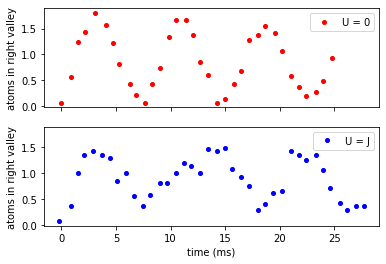

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(no_int_time, no_int_nR, "ro", label="U = 0", markersize=4)
ax2.plot(with_int_time, with_int_nR, "bo", label="U = J", markersize=4)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend()
ax2.legend()

## Analytical prediction

For the two atoms the Hamiltonian can be written down in the basis $\{LL, LR, RL, RR\}$ as:
    
$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

And we start out in the basis state $|LL\rangle$. So we can write

In [19]:
from scipy.sparse.linalg import expm

In [20]:
J = np.pi * 134
# in units of hbar
U = 0.7 * J;

In [21]:
Nt_an = 50
t_analytical = np.linspace(0, 20, Nt_an) * 1e-3
H_With_Int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_Wo_Int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

In [22]:
psi0 = np.zeros(4) * 1j
psi0[0] = 1.0 + 0j
print(psi0)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [23]:
psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for ii in np.arange(Nt_an):

    U_wo = expm(-1j * t_analytical[ii] * H_Wo_Int)
    psis_wo_int[:, ii] = np.dot(U_wo, psi0)

    U_w = expm(-1j * t_analytical[ii] * H_With_Int)
    psis_w_int[:, ii] = np.dot(U_w, psi0)

ps_wo = np.abs(psis_wo_int) ** 2
ps_w = np.abs(psis_w_int) ** 2

In [24]:
nR_wo = ps_wo[1, :] + ps_wo[2, :] + 2 * ps_wo[3, :]
nR_w = ps_w[1, :] + ps_w[2, :] + 2 * ps_w[3, :];

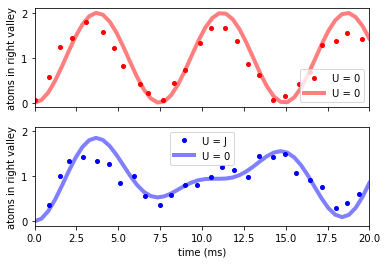

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

ax1.plot(no_int_time, no_int_nR, "ro", label="U = 0", markersize=4)
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="U = 0", linewidth=4, alpha=0.5)

ax2.plot(with_int_time, with_int_nR, "bo", label="U = J", markersize=4)
ax2.plot(t_analytical * 1e3, nR_w, "b-", label="U = 0", linewidth=4, alpha=0.5)

ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.set_xlim(0, 20)
ax1.legend()
ax2.legend()

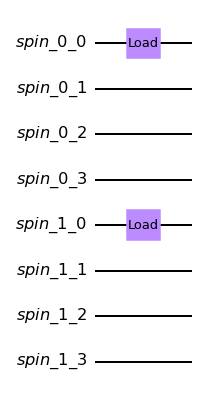

In [27]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()
backend = provider.get_backend("fermionic_tweezer_simulator")

# give initial occupations separated by spin species
qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])

qc.draw(output="mpl")

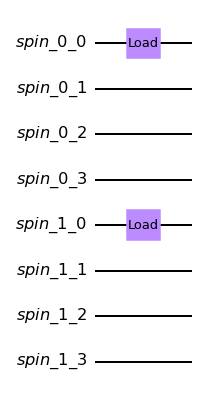

In [28]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()
backend = provider.get_backend("fermionic_tweezer_simulator")

# give initial occupations separated by spin species
qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])

qc.draw(output="mpl")

initialize the full dynamics

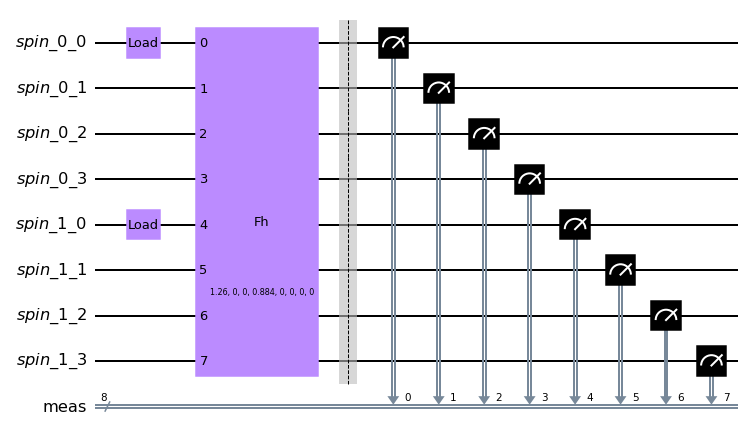

In [29]:
time = 3 * 1e-3

from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard

qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
all_modes = range(8)

qc.append(
    FermiHubbard(num_modes=8, j=[J * time, 0, 0], u=U * time, mu=[0 * time, 0, 0, 0]),
    qargs=all_modes,
)
qc.measure_all()
# alternatively append the FH gate directly:
# qc.FH(j=[0.5, 1., -1.], u=5., mu=[0., -1., 1., 0.], modes=all_modes)

qc.draw(output="mpl")

In [30]:
job = backend.run(qc, shots=100)

print("counts: ", job.result().get_counts())

counts:  {'01001000': 5, '10000100': 8, '10001000': 7, '01000100': 80}


/Users/fnj/gitKIP/qiskit-cold-atom/qiskit_cold_atom/fermions/fermion_gate_library.py:328: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  coeff * FermionicOp(label, register_length=self.num_modes)


In [31]:
def get_left_right_occupation(counts):
    sum_counts = 0
    nL = 0
    nR = 0
    for k, v in counts.items():
        # look for lefties
        sum_counts += v
        if int(k[0]):
            nL += v
        if int(k[4]):
            nL += v
        if int(k[1]):
            nR += v
        if int(k[5]):
            nR += v
    return nL / sum_counts, nR / sum_counts

In [32]:
get_left_right_occupation(job.result().get_counts())

(0.27, 1.73)

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following very simple circuit.

now let us simulate the time evolution

In [33]:
Ntimes = 25
times = np.linspace(0, 20, Ntimes) * 1e-3
means = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(
            num_modes=8, j=[J * time, 0, 0], u=0 * time, mu=[0 * time, 0, 0, 0]
        ),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means[i] = get_left_right_occupation(counts)
    if i % 10 == 0:
        print("step", i)
    # Calculate the resulting states after each rotation

step 0
step 10
step 20


and compare to the data

(0.0, 20.0)

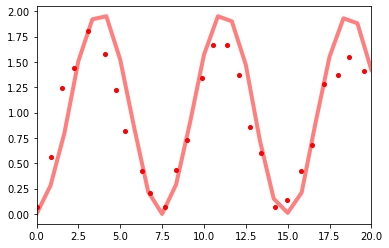

In [34]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="U = 0", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="U = 0", markersize=4)
ax1.set_xlim(0, 20)

## Hopping with interactions

In a next step the atoms are interacting. The circuit description of the experiment is the application of the hopping gate and the interaction gate. It can be written as

In [35]:
Ntimes = 25
times = np.linspace(0, 20, Ntimes) * 1e-3
means_int = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(
            num_modes=8, j=[J * time, 0, 0], u=U * time, mu=[0 * time, 0, 0, 0]
        ),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means_int[i] = get_left_right_occupation(counts)
    if i % 10 == 0:
        print("step", i)
    # Calculate the resulting states after each rotation

step 0
step 10
step 20


And we compare to the data to obtain

(0.0, 20.0)

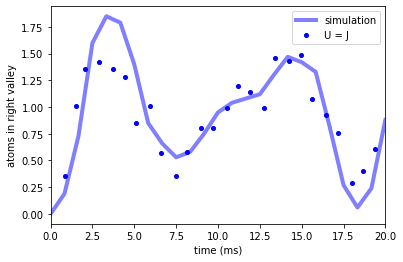

In [36]:
f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(times * 1e3, means_int, "b-", label="simulation", linewidth=4, alpha=0.5)
ax2.plot(with_int_time, with_int_nR, "bo", label="U = J", markersize=4)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## Summary

And finally we can compare the experimental data with all the descriptions.

(-1.0, 20.0)

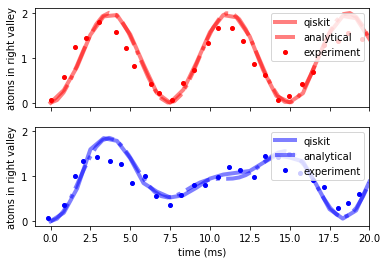

In [37]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)


ax1.plot(times * 1e3, means, "r-", label="qiskit", linewidth=4, alpha=0.5)
ax1.plot(t_analytical * 1e3, nR_wo, "r-.", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)

ax2.plot(times * 1e3, means_int, "b-", label="qiskit", linewidth=4, alpha=0.5)
ax2.plot(t_analytical * 1e3, nR_w, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_xlim(-1, 20)

# Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [synqs](htttps://qsimsim.synqs.org) provider. 


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this provider.</div>

In a first step, it is necessary to import the cold atom provider.

In [18]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import Parameter
from qiskit_cold_atom.synqs_fermions import LoadGate

from pprint import pprint

In [19]:
# save an account to disk
provider = ColdAtomProvider.enable_account(
    url=["http://qsimsim.synqs.org/singlequdit", "http://qsimsim.synqs.org/fermions"],
    username="synqs_test",
    token="Cm2TXfRmXennMQ5",
)
fermion_device_backend = provider.get_backend("synqs_fermionic_tweezer_simulator")
pprint(fermion_device_backend.configuration().supported_instructions)

['load', 'measure', 'barrier', 'hop', 'int', 'phase']


As you can see the back-end is only implementation a limited set of back-ends such that the full circuit has to be trotterized.

In [20]:
theta_j = Parameter("theta_j")
theta_u = Parameter("theta_u")

# the parameters of the experiment
J = np.pi * 134
U = 0.7 * J
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
theta_us = U * times
means_int = np.zeros(Ntimes)
Ntrott = 15

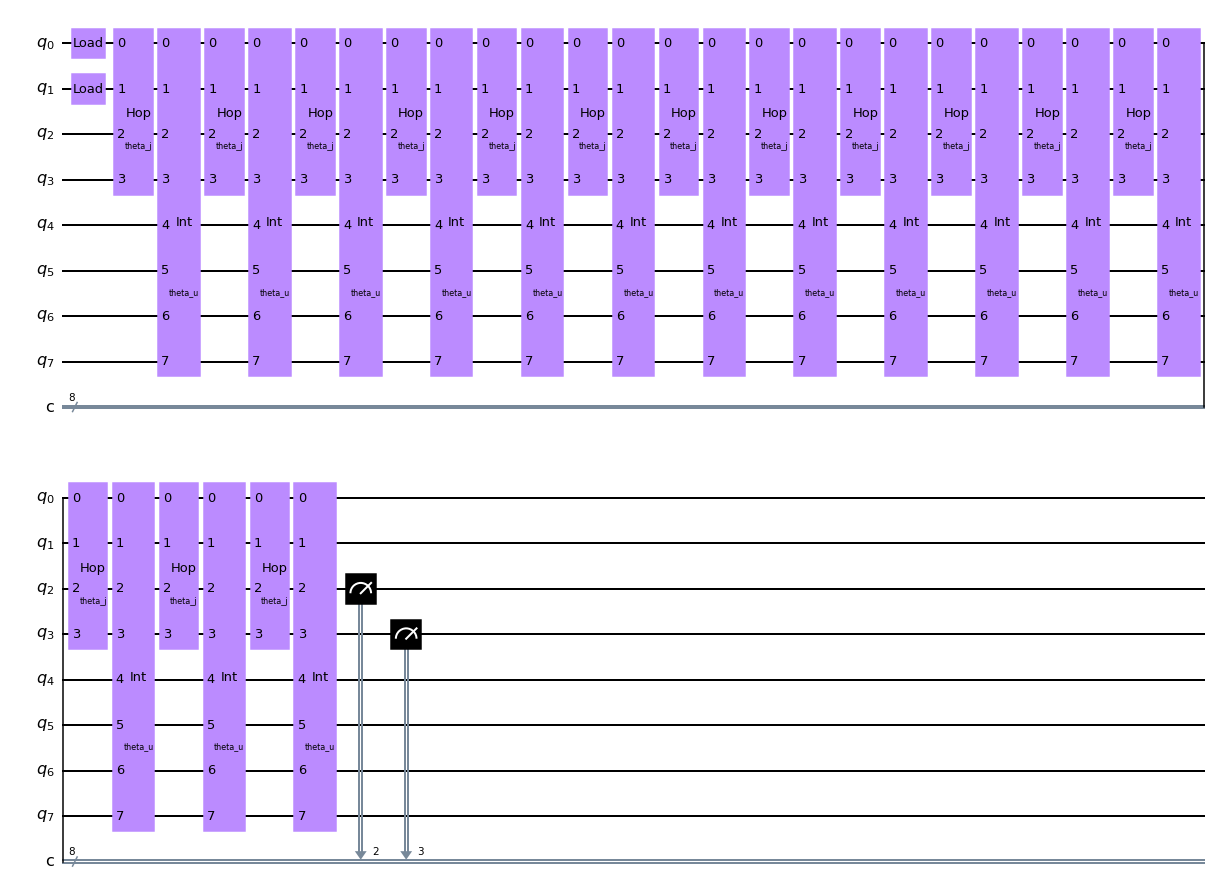

In [21]:
circuit2 = QuantumCircuit(8, 8)
circuit2.load(0)
circuit2.load(1)
for ii in range(Ntrott):
    circuit2.hop(list(range(0, 4)), theta_j)
    circuit2.inter(list(range(0, 8)), theta_u)
circuit2.measure(2, 2)
circuit2.measure(3, 3)
circuit2.draw(output="mpl")

next we set up the circuits that calculate each time step and send it to the back-end

In [26]:
circuit2_list = [
    circuit2.bind_parameters(
        {
            theta_j: (theta1 / Ntrott) % (2 * np.pi),
            theta_u: (theta2 / Ntrott) % (2 * np.pi),
        }
    )
    for (theta1, theta2) in zip(theta_js, theta_us)
]
job2 = fermion_device_backend.run(circuit2_list, shots=500)

You will now have to save the job and wait und the job status has changed to done. 

In [30]:
pprint(job2.job_id())

'20211123_074153-fermions-synqs_test-88bda'


In [31]:
job_retrieved2 = fermion_device_backend.retrieve_job(job_id=job2.job_id())
print("job status: ", job_retrieved2.status())

job status:  JobStatus.DONE


Once the job is done, we can obtain once again the usual result, which was saved on the back-end, before we change it such that it can compared to the experimental data.

(0.0, 20.0)

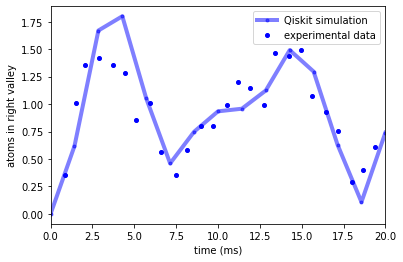

In [39]:
result2 = job_retrieved2.result()
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i in range(Ntimes):
    means_int[i] = (
        np.array(list(map(str.split, outcomes2[i]))).astype("int").sum(axis=1).mean()
    )


f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(
    times * 1e3, means_int, "b.-", label="Qiskit simulation", linewidth=4, alpha=0.5
)
ax2.plot(
    with_int_time,
    with_int_nR,
    "bo",
    label="experimental data",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)